TODO: 
* (A) Add more flow charts...
    * one at the beginning that covers it all, 
    * a version of the document one without the "3B" step
* (J/L) Add and check prose, especially in the topic embedding step
* (A?)Add a basic word embedding visualization
* (J/L) I'm ambivalent about keeping the parameter discussion for the word embedding example. I'm leaning towards taking it out, and referencing notebook 03 where it came from. If there's going to be a parameter discussion in the word section, there should probably be somethign in the document and topic sections as well.
* (A) Final rerun with updated vectorizers library once all else is stabilized

# Vectorizers Quickstart
## I don't care why it works, just show me what to do

The goal of this notebook is to show our recommended approaches on how to use the tools in the [Tutte Institute ``vectorizers`` library](https://github.com/TutteInstitute/vectorizers) to construct word, document and topic vectorizations and embeddings.


## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src import paths
from src.data import Dataset
from src.user.viz import topic_word_by_class, topic_word_by_cluster

In [3]:
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text
import sklearn.preprocessing
import scipy.sparse
import vectorizers
import vectorizers.transformers
import umap
import umap.plot
import pynndescent
import seaborn as sns
import matplotlib.colors
import warnings
from bokeh.plotting import show

warnings.simplefilter("ignore")
sns.set()

## Dataset Setup
For the sake of example, we will use the 20 newsgroup dataset as prepared via notebook `00-20-newsgroups-setup.ipynb`.

In [4]:
ds = Dataset.load('20_newsgroups_pruned')
print(ds.DESCR)


The 20 Newsgroups dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian).

Here are the categories:

 * `alt.atheism`,
 * `comp.graphics`,
 * `comp.os.ms-windows.misc`,
 * `comp.sys.ibm.pc.hardware`,
 * `comp.sys.mac.hardware`,
 * `comp.windows.x`,
 * `misc.forsale`,
 * `rec.autos`,
 * `rec.motorcycles`,
 * `rec.sport.baseball`,
 * `rec.sport.hockey`,
 * `sci.crypt`,
 * `sci.electronics`,
 * `sci.med`,
 * `sci.space`,
 * `soc.religion.christian`,
 * `talk.politics.guns`,
 * `talk.politics.mideast`,
 * `talk.politics.misc`,
 * `talk.religion.misc`

The current version is obtained by wrapping `sklearn.datasets.fetch_20newsgroups

## Tokenize

In [5]:
%%time
cv = sklearn.feature_extraction.text.CountVectorizer(lowercase=True)
sk_word_tokenize = cv.build_tokenizer()
sk_preprocesser = cv.build_preprocessor()
tokenize = lambda doc: sk_word_tokenize(sk_preprocesser(doc))
tokenized_news = [tokenize(doc) for doc in ds.data]

CPU times: user 2.13 s, sys: 234 ms, total: 2.36 s
Wall time: 3.52 s


## Word Embedding

The first thing we'll do is a word vectorization, as we will use this as input data to our document and topic embeddings as well. This is comparable to classic algorithms like word2vec and GloVe. In the `vectorizers` library, we can embed words using the ``TokenCooccurrenceVectorizer``. This tool counts token cooccurrences in windows within a set of token sequences. In other words, it creates a vocabulary by vocabulary sparse matrix where an entry counts how often two tokens cooccurred within some range of each other in the entire set of sequences. This is what is going on at the heart of algorithms like word2vec and GloVe.

The ``TokenCooccurrenceVectorizer`` makes this direct counting approach available for *generic* token sequences in addition to text, and provides flexibility and options as to how windows are constructed, weighted, and so on.

#### Setting parameters for ``TokenCooccurrenceVectorizer``
Since we don't have a lot of text in the 20 newsgroups dataset, we won't use any of the advanced functionality.

We'll restrict to tokens that occur in at least 5 documents (pruning out rare words that won't likely be useful or informative).

For our window radii, we'll take a large window (arbitrarily selected to be 20) to capture as much context as possible. Given this large large size of the window, we apply a decaying kernel to ensure that nearby words are given more importance that words that are far way. In this case, we use a "geometric" kernel over the window, giving less weight (in a geometric progression) to words further away in the window.

The ``TokenCooccurrenceVectorizer`` also supports the use of an iterative expectation-maximization algorithm to refine the kernel weighting of words within windows, but with so little data this will not be worthwhile (so we set ``n_iters=0``).

Finally it is worth noting that by default ``TokenCooccurrenceVectorizer`` uses directional windowing, keeping track of occurrences before, and after, a given word separately. We will leave this in place: we believe that word order is important in english sentences and that intuition has been born out in practice.

Once the cooccurrences are counted, it remains to convert the sparse matrix into dense word vectors. Conveniently this is coded up as the ``reduce_dimension`` method in the ``TokenCooccurrenceVectorizer``. The ``reduce_dimension`` method:
1. normalizes columns,
2. normalizes rows, 
3. applies a transform on to make euclidean distance in the transformed space a better approximation to Hellinger distance in the original space, and 
4. applies a standard SVD to get dense vectors. 

In [6]:
%%time
word_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
    min_document_occurrences=5,
    window_radii=20,          
    window_functions='variable',
    kernel_functions='geometric',            
    n_iter = 0,
    normalize_windows=True,
).fit(tokenized_news)
word_vectors = word_vectorizer.reduce_dimension(dimension=160, algorithm="randomized")

CPU times: user 7min 15s, sys: 19.3 s, total: 7min 34s
Wall time: 8min 37s


In [7]:
## insert basic viz

## Document Embedding

There are 3 steps to obtain the Approximate Wasserstein Embedding document embedding: 
1. **Bag-of-words Embedding** via `NgramVectorizer`: This step uses a bag-of-words approach to vectorize documents. 
2. **Information Weight Embedding** via `InformationWeightTransformer`: This step takes an information theoretic view to generating feature weights for count data (inspired by TF-IDF). 
3. **Approximate Wasserstein Embedding (AWE)** via `ApproximateWassersteinVectorizer`: This step takes into account the fact that our words are not independent of each other and should be treated as distributions in their own right. This is a linear algebra approximation to the Wasserstein Embedding (WE) (aka. the fast way to do WE).
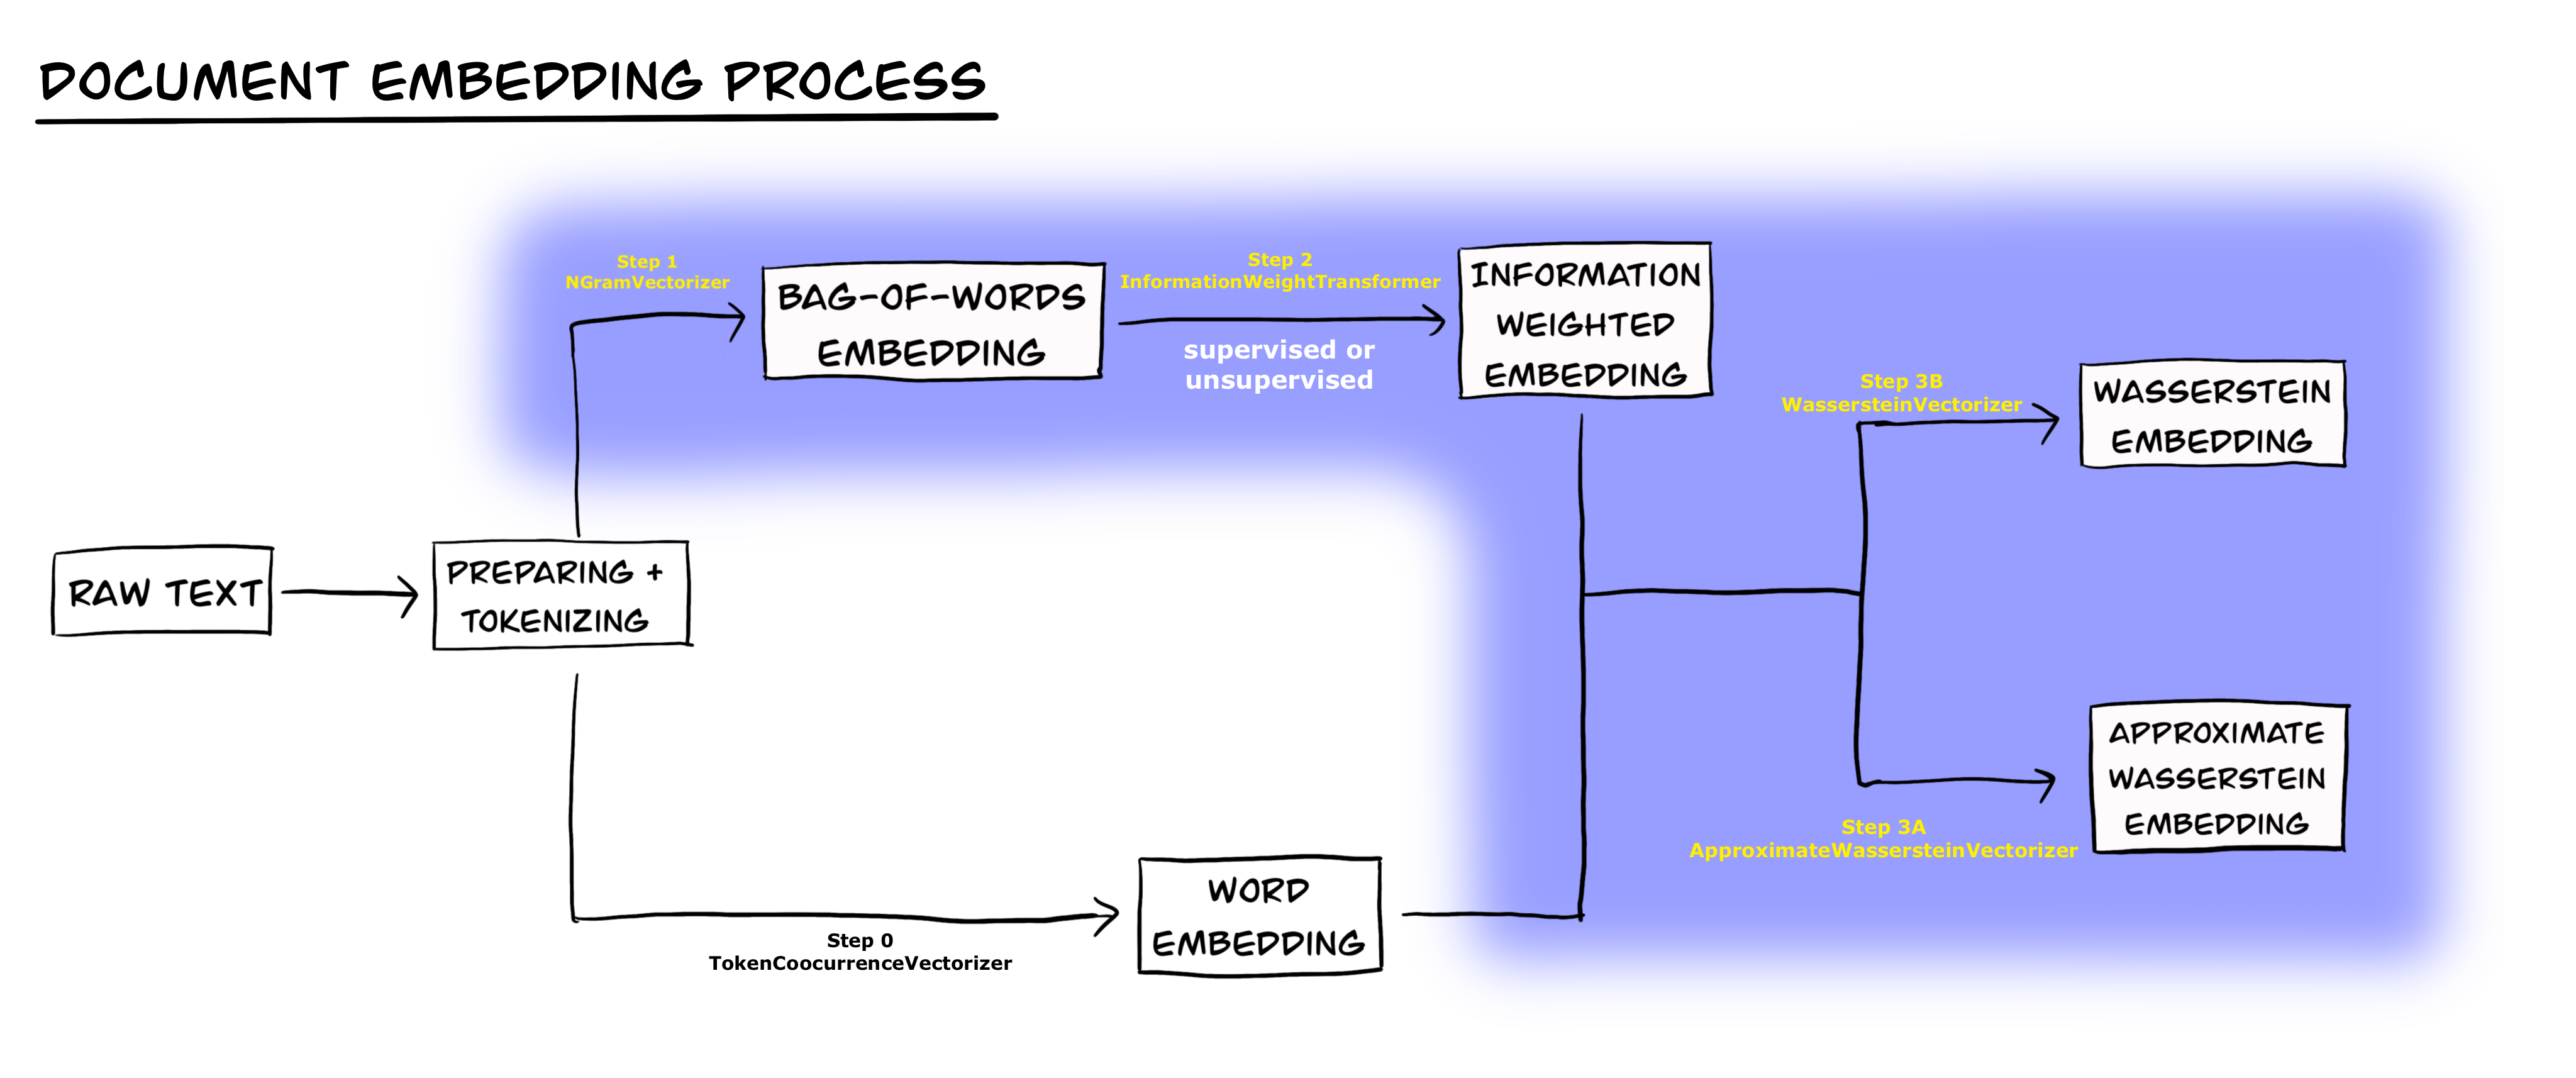

See notebook `03-document-embbeddings.ipynb` to see a walkthrough of this process in detail and to see comparisons with other common document embedding approaches such as USE and BERT.



In [8]:
%%time
bow_vectors = vectorizers.NgramVectorizer(
    token_dictionary=word_vectorizer.token_label_dictionary_
).fit_transform(tokenized_news)

CPU times: user 19.6 s, sys: 300 ms, total: 19.9 s
Wall time: 20.7 s


In [9]:
%%time
info_transformer = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
)
info_doc_vectors = info_transformer.fit_transform(bow_vectors)

CPU times: user 4.38 s, sys: 51.2 ms, total: 4.43 s
Wall time: 4.67 s


In [10]:
%%time
awe_vectorizer = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
)
awe_doc_vectors = awe_vectorizer.fit_transform(info_doc_vectors, vectors=word_vectors)

CPU times: user 3.44 s, sys: 178 ms, total: 3.61 s
Wall time: 2.37 s


In [11]:
%%time
awe_doc_mapper = umap.UMAP(metric="cosine", random_state=42).fit(awe_doc_vectors)

CPU times: user 44.6 s, sys: 460 ms, total: 45.1 s
Wall time: 44.8 s


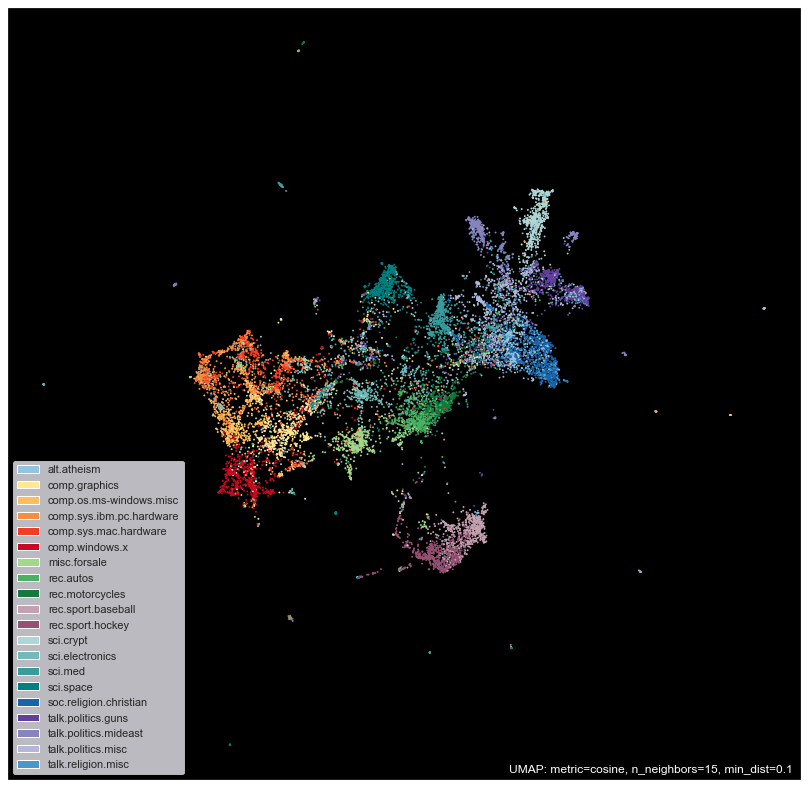

In [12]:
umap.plot.points(
    awe_doc_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in ds.target]),
    color_key=ds.COLOR_KEY,
    background="black",
    width=1024,
    height=1024,
);

## Topic Embedding

In addition to existing `awe_doc_vectors`

In [13]:
awe_word_vectors = awe_vectorizer.transform(info_transformer.transform(scipy.sparse.eye(word_vectors.shape[0])))

In [14]:
%%time
awe_topic_mapper = umap.UMAP(metric="cosine", random_state=42).fit(np.vstack([awe_doc_vectors, awe_word_vectors]))

CPU times: user 50.7 s, sys: 717 ms, total: 51.4 s
Wall time: 43 s


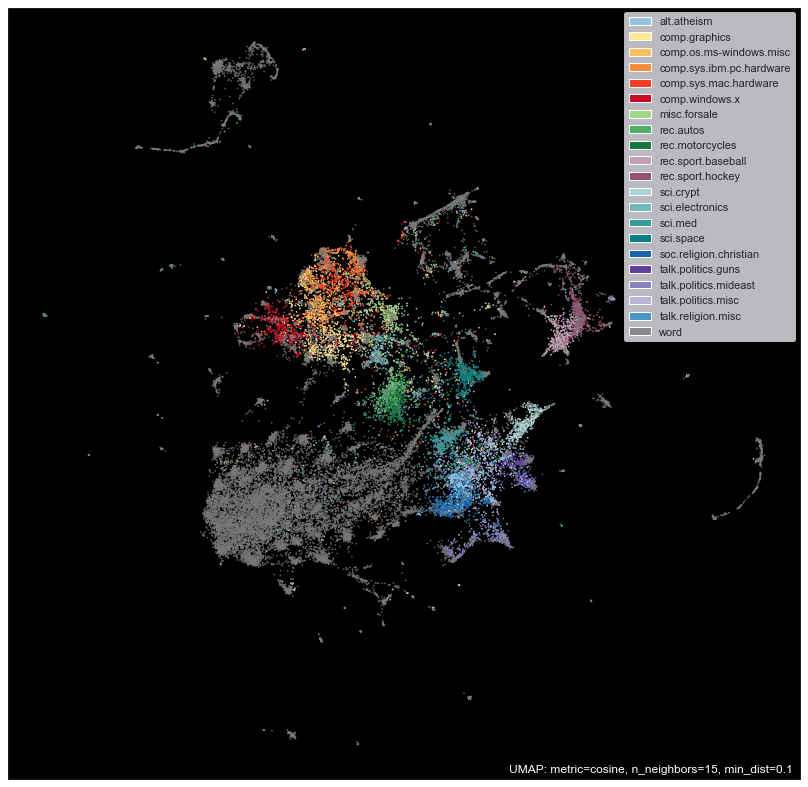

In [15]:
umap.plot.points(
    awe_topic_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in ds.target] + ["word"] * awe_word_vectors.shape[0]),
    color_key=ds.COLOR_KEY,
    background="black",
    width=1024,
    height=1024,
);

### Topic word by Newsgroup

CPU times: user 5min 48s, sys: 33.3 s, total: 6min 21s
Wall time: 7min 15s


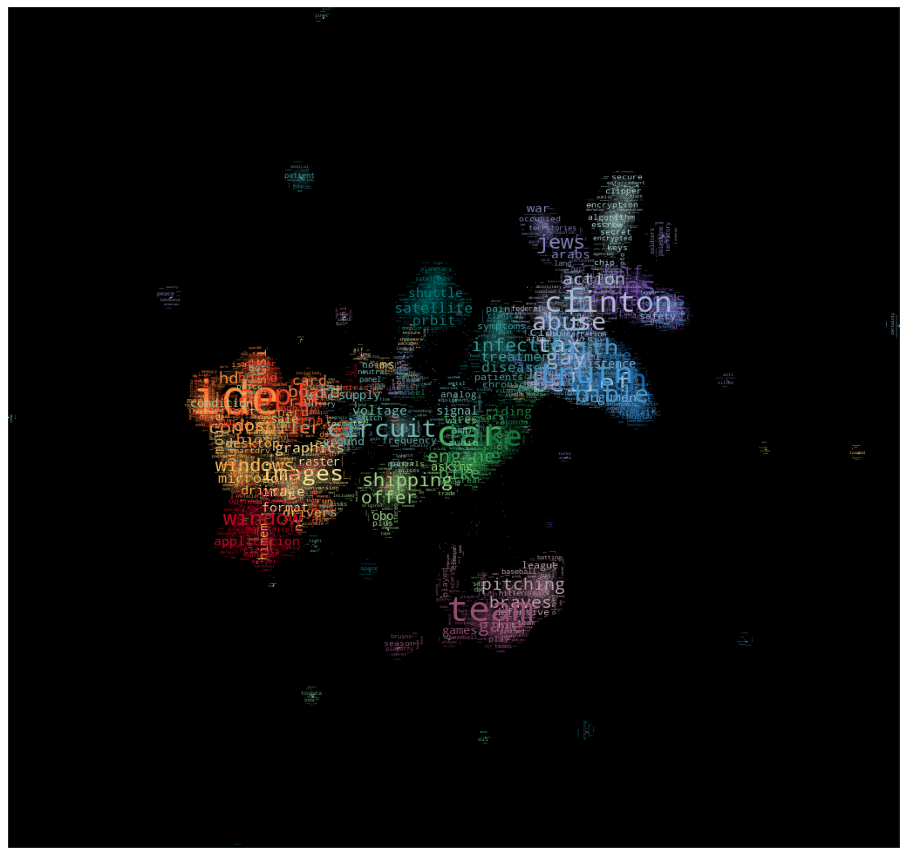

In [16]:
%%time
topic_word_by_class(
    awe_doc_vectors,
    awe_word_vectors,
    ds.target, 
    ds.metadata['target_names'],
    lambda x: word_vectorizer.token_index_dictionary_[x],
    ds.COLOR_KEY,
    background="black"
)

### Topic word by cluster

In [ ]:
%%time
low_dim_rep = umap.UMAP(
    metric="cosine", n_components=5, min_dist=1e-4, random_state=42, n_epochs=500
).fit_transform(awe_doc_vectors)
cluster_labels = hdbscan.HDBSCAN(min_cluster_size=25).fit_predict(low_dim_rep)
color_key = [matplotlib.colors.rgb2hex(x) for x in sns.color_palette("rainbow", np.max(cluster_labels) + 1)]
topic_word_by_cluster(
    awe_doc_vectors, 
    awe_word_vectors, 
    cluster_labels,
    lambda x: word_vectorizer.token_index_dictionary_[x],
    color_key,
    n_neighbors=150,
    background="black",
    kernel="cosine",
);